<a href="https://colab.research.google.com/github/Nazaruk-Anton/Course_Recommender_System/blob/main/6_Clustering_based_course_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clustering based Course Recommender System**


Previously, we have generated user profile vectors based on course ratings and genres.

A user profile vector may look like a row vector in the following matrix, for example, we can see the Database column for user2 has a value 1 which means user2 is very interesting in courses related to the databases. With the user profile vectors generated, we can also easily compute the similarity among users based on their shared interests.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module\_3/images/userprofiles.png)


Furthermore, we could perform clustering algorithms such as K-means or DBSCAN to group users with similar learning interests. For example, in the below user clusters, we have user clusters whom have learned courses related to machine learning, cloud computing, databases, and web development, etc.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module\_3/images/userprofiles_clustering.png)


For each user group, we can come up with a list of popular courses. For example, for the machine learning user cluster/learning group, we can count the most frequently enrolled courses, which are very likely to be the most popular and good machine learning courses because they are enrolled by many users who are interested in machine learning.

If we know a user belongs to the machine learning group, we may recommend the most enrolled courses to them and it is very likely the user will be interested in them.


## Objectives


*   Perform k-means clustering on the original user profile feature vectors
*   Apply PCA (Principle Component Analysis ) on user profile feature vectors to reduce dimensions
*   Perform k-means clustering on the PCA transformed main components
*   Generate course recommendations based on other group members' enrollment history


***


## Prepare and setup lab environment


First install and import required libraries:


In [2]:
!pip install scikit-learn==1.0.2
!pip install seaborn==0.11.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 45.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.0/285.0 KB 6.2 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

In [4]:
# also set a random state
rs = 123

### Load the user profile dataset


Let's first load the original user profile feature vectors:


In [5]:
user_profile_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_profile.csv"
user_profile_df = pd.read_csv(user_profile_url)
user_profile_df.head()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,52.0,14.0,6.0,43.0,3.0,33.0,0.0,29.0,41.0,2.0,18.0,34.0,9.0,6.0
1,4,40.0,2.0,4.0,28.0,0.0,14.0,0.0,20.0,24.0,0.0,6.0,6.0,0.0,2.0
2,5,24.0,8.0,18.0,24.0,0.0,30.0,0.0,22.0,14.0,2.0,14.0,26.0,4.0,6.0
3,7,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,8,6.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0


In [6]:
user_profile_df.shape

(33901, 15)

we can then list the feature names, they are the user interested topics (course genres):


In [7]:
feature_names = list(user_profile_df.columns[1:])
feature_names

['Database',
 'Python',
 'CloudComputing',
 'DataAnalysis',
 'Containers',
 'MachineLearning',
 'ComputerVision',
 'DataScience',
 'BigData',
 'Chatbot',
 'R',
 'BackendDev',
 'FrontendDev',
 'Blockchain']

As we can see from the user profile dataset, we have about 33K unique users with interests in areas like `Database`, `Python`, `CloudComputing`, etc. Then, let's check the  summary statistics for each feature.


In [8]:
user_profile_df.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000
mean,1.064064e+06,5.518569,3.493791,2.307100,3.624701,0.998938,3.048022,0.001770,5.087343,4.750450,0.462995,1.017433,2.269461,0.315802,0.986844
std,4.972578e+05,7.611941,4.227254,3.841858,4.760135,2.351764,4.624004,0.072846,5.230697,7.216228,1.055186,2.342532,4.310752,1.363462,1.950585
min,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.813480e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.043907e+06,3.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.451159e+06,9.000000,6.000000,3.000000,6.000000,0.000000,3.000000,0.000000,9.000000,6.000000,0.000000,0.000000,3.000000,0.000000,2.000000
max,2.103039e+06,63.000000,18.000000,38.000000,48.000000,15.000000,39.000000,3.000000,32.000000,54.000000,6.000000,18.000000,54.000000,15.000000,12.000000


The original user profile feature vector is not normalized, which may cause issues when we perform clustering and Principal component analysis (PCA), therefor we standardize the data.


In [9]:
# Use StandardScaler to make each feature with mean 0, standard deviation 1
scaler = StandardScaler()
user_profile_df[feature_names] = scaler.fit_transform(user_profile_df[feature_names])
print("mean {} and standard deviation{} ".format(user_profile_df[feature_names].mean(),user_profile_df[feature_names].std()))

mean Database          -3.353495e-17
Python            -5.700942e-17
CloudComputing    -3.521170e-17
DataAnalysis      -7.671120e-17
Containers         3.353495e-18
MachineLearning    3.688845e-17
ComputerVision    -1.509073e-17
DataScience       -1.676748e-17
BigData            6.706990e-17
Chatbot           -6.874665e-17
R                  4.233788e-17
BackendDev         1.383317e-17
FrontendDev        5.051202e-17
Blockchain        -5.281755e-17
dtype: float64 and standard deviationDatabase           1.000015
Python             1.000015
CloudComputing     1.000015
DataAnalysis       1.000015
Containers         1.000015
MachineLearning    1.000015
ComputerVision     1.000015
DataScience        1.000015
BigData            1.000015
Chatbot            1.000015
R                  1.000015
BackendDev         1.000015
FrontendDev        1.000015
Blockchain         1.000015
dtype: float64 


In [10]:
user_profile_df.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04
mean,1.064064e+06,-3.353495e-17,-5.700942e-17,-3.521170e-17,-7.671120e-17,3.353495e-18,3.688845e-17,-1.509073e-17,-1.676748e-17,6.706990e-17,-6.874665e-17,4.233788e-17,1.383317e-17,5.051202e-17,-5.281755e-17
std,4.972578e+05,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,2.000000e+00,-7.249991e-01,-8.265040e-01,-6.005256e-01,-7.614816e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-9.726080e-01,-6.583107e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
25%,6.813480e+05,-7.249991e-01,-8.265040e-01,-6.005256e-01,-7.614816e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-9.726080e-01,-6.583107e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
50%,1.043907e+06,-3.308757e-01,-1.168130e-01,-6.005256e-01,-1.312380e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-3.990622e-01,-3.811535e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
75%,1.451159e+06,4.573712e-01,5.928781e-01,1.803581e-01,4.990056e-01,-4.247674e-01,-1.038556e-02,-2.429612e-02,7.480294e-01,1.731609e-01,-4.387873e-01,-4.343370e-01,1.694715e-01,-2.316212e-01,5.194189e-01
max,2.103039e+06,7.551593e+00,3.431642e+00,9.290667e+00,9.322416e+00,5.953517e+00,7.775190e+00,4.115884e+01,5.145214e+00,6.824934e+00,5.247500e+00,7.249771e+00,1.200053e+01,1.076995e+01,5.646161e+00


The normalized user profile features are:


In [11]:
features = user_profile_df.loc[:, user_profile_df.columns != 'user']
features

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,6.106474,2.485388,0.961242,8.272010,0.850889,6.477594,-0.024296,4.571668,5.023412,1.456642,7.249771,7.360899,6.369323,2.570116
1,4.529980,-0.353377,0.440653,5.120792,-0.424767,2.368540,-0.024296,2.851031,2.667576,-0.438787,2.127032,0.865416,-0.231621,0.519419
2,2.427988,1.066006,4.084776,4.280467,-0.424767,5.828796,-0.024296,3.233395,1.281790,1.456642,5.542191,5.505047,2.702132,2.570116
3,-0.462250,-0.826504,-0.600526,-0.341319,-0.424767,-0.659184,-0.024296,-0.972608,-0.381153,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
4,0.063248,-0.826504,-0.600526,0.078843,-0.424767,-0.659184,-0.024296,-0.972608,0.173161,-0.438787,0.419453,-0.526473,-0.231621,-0.505930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,-0.330876,-0.116813,0.180358,0.499006,-0.424767,-0.659184,-0.024296,0.174484,-0.658311,-0.438787,2.127032,0.865416,-0.231621,1.032093
33897,-0.724999,-0.826504,-0.079936,-0.761482,-0.424767,-0.659184,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
33898,-0.330876,0.592878,0.961242,-0.761482,-0.424767,2.368540,-0.024296,0.748029,-0.658311,-0.438787,0.846348,-0.526473,-0.231621,-0.505930
33899,-0.724999,-0.826504,-0.600526,-0.761482,-0.424767,-0.226652,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930


we can also save the user ids for later recommendation tasks:


In [12]:
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']
user_ids

,user
0,2
1,4
2,5
3,7
4,8
...,...
33896,2102054
33897,2102356
33898,2102680
33899,2102983


### Performing K-means clustering algorithm on the user profile feature vectors


For `KMeans` algorithm, one important hyperparameter is the number of clusters `n_cluster`, and a good way to find the optimized `n_cluster` is using to grid search a list of candidates and find the one with the best or optimized clustering evaluation metrics such as minimal `sum of squared distance`:


*Grid search the optimized n_cluster for KMeans() model*


In [13]:
import warnings
def warn(*args,**kwargs):
    pass
warnings.warn = warn

In [14]:


distorsions = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features)
    distorsions.append(kmeans.inertia_)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f5f6eb5e5e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.9/dist-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/usr/local/lib/python3.9/dist-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.9/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error


Text(0.5, 1.0, 'Elbow curve')

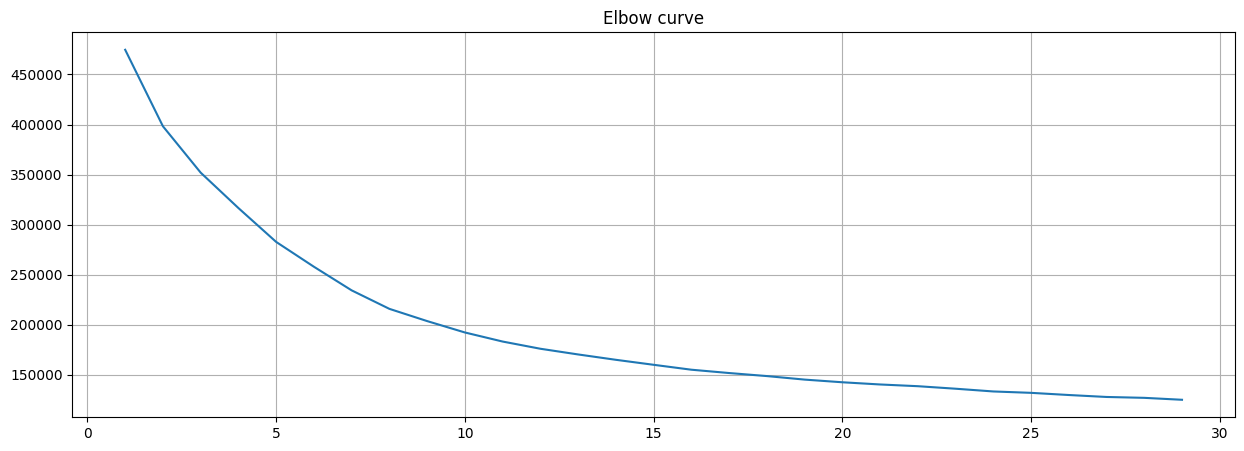

In [16]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 30), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [17]:
cluster_labels = kmeans.labels_
cluster_labels.shape

(33901,)

Applying KMeans() on the features with optimized n_cluster parameter after model fitting, you can find output cluster labels in `model.labels_` attribute


In [18]:
model = KMeans(n_clusters=13)
model.fit(features)
model.labels_

array([11, 11,  4, ...,  3,  0,  0], dtype=int32)

The cluster labels you generated is a list of integers indicating cluster indices. You may use the following utility method to combine the cluster labels and user ids to a dataframe, so that you know which cluster a user belongs:


In [19]:
def combine_cluster_labels(user_ids, labels):
    labels_df = pd.DataFrame(labels)
    cluster_df = pd.merge(user_ids, labels_df, left_index=True, right_index=True)
    cluster_df.columns = ['user', 'cluster']
    return cluster_df

In [21]:
combine_cluster_labels(user_ids, cluster_labels)

,user,cluster
0,2,20
1,4,23
2,5,20
3,7,0
4,8,22
...,...,...
33896,2102054,13
33897,2102356,0
33898,2102680,15
33899,2102983,0


Now, each user finds its own cluster or we can say we have created many clusters of learning communities. Learners within each community share very similar learning interests.


### Apply PCA on user profile feature vectors to reduce dimensions


In the previous step, we applied `KMeans` on the original user profile feature vectors which have 14 original features (the course genres).


In [22]:
features = user_profile_df.loc[:, user_profile_df.columns != 'user']
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']
feature_names = list(user_profile_df.columns[1:])

In [23]:
print(f"There are {len(feature_names)} features for each user profile.")

There are 14 features for each user profile.


If we plot a covariance matrix of the user profile feature vectors with 14 features, we can observe that some features are actually correlated:


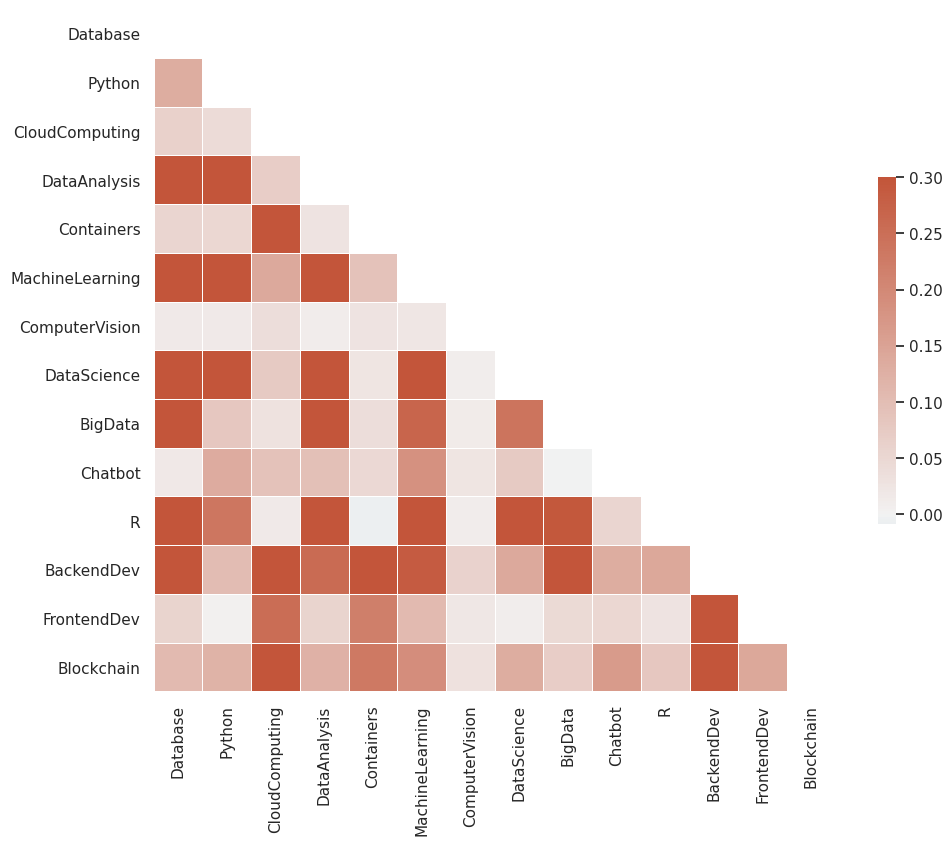

In [24]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = features.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.show()

For example, the feature `MachineLearning` and the feature `DataScience` are correlated. Such covariances among features may indicate that we can apply PCA to find its main components (eigenvectors with max eigenvalues on the covariance matrix).

If we only keep the independent main components, then we can reduce the dimensions of our user profile feature vectors.


Now let's apply the `PCA()` provided by  `scikit-learn` to find the main components in user profile feature vectors and see if we can reduce its dimensions by only keeping the main components.


*Find the optimized `n_components` for PCA*


In [25]:
accVarRatio = []

for n_components in range(1, 15):
    pca = PCA(n_components=n_components)
    pca.fit(features)

    print(pca.explained_variance_ratio_.sum())
    print(pca.singular_values_)

    accVarRatio.append(pca.explained_variance_ratio_.sum())

0.2875684338769967
[369.43741645]
0.4630925644817141
[369.43741645 288.6281513 ]
0.5761339643675617
[369.43741645 288.6281513  231.62692194]
0.648746562783235
[369.43741645 288.6281513  231.62692194 185.64200975]
0.7194878762997209
[369.43741645 288.6281513  231.62692194 185.64200975 183.23432477]
0.7882103410314036
[369.43741645 288.6281513  231.62692194 185.64200975 183.23432477
 180.60078592]
0.8429558465572836
[369.43741645 288.6281513  231.62692194 185.64200975 183.23432477
 180.60078592 161.19237997]
0.8944445500368897
[369.43741645 288.6281513  231.62692194 185.64200975 183.23432477
 180.60078592 161.19237997 156.32421282]
0.9272695591307683
[369.43741645 288.6281513  231.62692194 185.64200975 183.23432477
 180.60078592 161.19237997 156.32421282 124.81670107]
0.9544658170614712
[369.43741645 288.6281513  231.62692194 185.64200975 183.23432477
 180.60078592 161.19237997 156.32421282 124.81670107 113.61216819]
0.9733572103164786
[369.43741645 288.6281513  231.62692194 185.64200975

<Axes: xlabel='n_component', ylabel='accumulated variance ratio'>

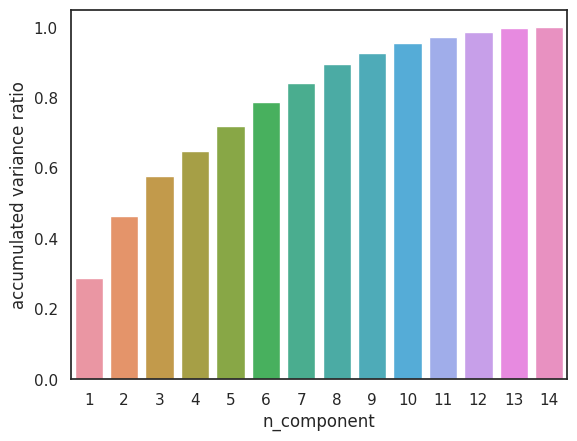

In [26]:
plot_df = pd.DataFrame({'n_component': range(1, 15), 'accumulated variance ratio': accVarRatio})
sns.barplot(x='n_component', y='accumulated variance ratio', data=plot_df)

*Performing PCA to transform original user profile features*


In [27]:
for i in range(len(accVarRatio)):
    if accVarRatio[i] > 0.9:
        print(i)

8
9
10
11
12
13


In [34]:
# We select n_component = 8, due to the minimal ratio > 0.9
pca = PCA(n_components=8)
pca.fit(features)
transformed_features = pca.transform(features)
print(transformed_features)

[[17.77249439  0.20068141  1.73060927 ...  2.70715444  0.681042
   2.31261304]
 [ 7.14519863 -2.84748121  2.3586356  ... -0.13453283  0.54976933
   0.46903346]
 [11.36326985  1.8736192  -1.52207738 ...  0.88321221  1.67758234
   2.9376687 ]
 ...
 [ 0.62594328 -0.54716673 -1.69282423 ...  0.67624374 -0.05509971
   0.58209105]
 [-2.03683187 -0.15353383  0.16285226 ...  0.25510924  0.07249638
   0.11374975]
 [-2.03683187 -0.15353383  0.16285226 ...  0.25510924  0.07249638
   0.11374975]]


In [35]:
new_df = pd.DataFrame(transformed_features)
new_df.insert(0, "user", user_ids, True)
new_df. columns = ['user'] + [f'PC{i}' for i in range(8)]

### Perform k-means clustering on the PCA transformed feature vectors


*Performing K-means on the PCA transformed features*


In [36]:
distorsions = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(transformed_features)
    distorsions.append(kmeans.inertia_)

In [37]:
kmeans = KMeans(n_clusters=25)
kmeans.fit(transformed_features)
cluster_labels = kmeans.labels_
cluster_labels.shape

(33901,)

In [38]:
cluster_df = combine_cluster_labels(user_ids, cluster_labels)
cluster_df

,user,cluster
0,2,22
1,4,10
2,5,15
3,7,3
4,8,21
...,...,...
33896,2102054,20
33897,2102356,3
33898,2102680,20
33899,2102983,3


Great, now all users find their learning interest groups, either based on their original or the PCA transformed user profile features.


When a user is in a group or a community, it is very likely that the user will be interested in the courses enrolled by other members within the same group.


###Generating course recommendations based on the popular courses in the same cluster


Next, suppose we have a set of test users, and we want to recommend new courses to them using a clustering-based recommender system:


In [40]:
test_user_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/rs_content_test.csv"
test_users_df = pd.read_csv(test_user_url)[['user', 'item']]
test_users_df.head()

,user,item
0,1502801,RP0105EN
1,1609720,CNSC02EN
2,1347188,CO0301EN
3,755067,ML0103EN
4,538595,BD0115EN


In [42]:
test_users_labelled = pd.merge(test_users_df, cluster_df, left_on='user', right_on='user')
test_users_labelled

,user,item,cluster
0,1502801,RP0105EN,1
1,1502801,BD0131EN,1
2,1502801,BD0212EN,1
3,1502801,BD0115EN,1
4,1502801,BD0211EN,1
...,...,...,...
9397,630511,BD0121EN,21
9398,630511,SC0101EN,21
9399,630511,BD0111EN,21
9400,630511,BD0115EN,21


From the above dataframe, we know each user's enrolled courses and its cluster index. If we use a groupby and sum aggregation, we can get the enrollments count for each course in each group, like the following code snippet:



In [43]:
courses_cluster = test_users_labelled[['item', 'cluster']]
courses_cluster['count'] = [1] * len(courses_cluster)
count_enrollments_df = courses_cluster.groupby(['cluster','item']).agg(enrollments = ('count','sum')).reset_index()
count_enrollments_df

,cluster,item,enrollments
0,0,AI0111EN,1
1,0,BC0101EN,1
2,0,BD0101EN,25
3,0,BD0111EN,11
4,0,BD0123EN,1
...,...,...,...
1371,24,ST0101EN,3
1372,24,TA0105,2
1373,24,TA0105EN,1
1374,24,TMP0105EN,1


*For each test user, try to recommend any unseen courses based on the popular courses in his/her cluster. You may use an enrollment count threshold (such as larger than 10) to determine if it is a popular course in the cluster*


In [48]:
popular_courses_by_cluster = {}
for i in range(25):
    tmp_df = count_enrollments_df[count_enrollments_df['cluster']==i]
    tmp_df.sort_values(by=['enrollments'], ascending=False, inplace=True)
    popular_courses_by_cluster[i] = tmp_df['item'].values[:3]
    print(f'user in cluster {i} will be sugessted 3 courses as {popular_courses_by_cluster[i]}')
    
for index, row in test_users_labelled.iterrows():
    user = row['user']
    cluster = row['cluster']
    print(f'user {user} in cluster {cluster} is recommened 3 courses as {popular_courses_by_cluster[cluster][:3]}')

Streaming output truncated to the last 5000 lines.
user 964237 in cluster 18 is recommened 3 courses as ['RP0101EN' 'PY0101EN' 'DS0101EN']
user 964237 in cluster 18 is recommened 3 courses as ['RP0101EN' 'PY0101EN' 'DS0101EN']
user 964237 in cluster 18 is recommened 3 courses as ['RP0101EN' 'PY0101EN' 'DS0101EN']
user 964237 in cluster 18 is recommened 3 courses as ['RP0101EN' 'PY0101EN' 'DS0101EN']
user 964237 in cluster 18 is recommened 3 courses as ['RP0101EN' 'PY0101EN' 'DS0101EN']
user 964237 in cluster 18 is recommened 3 courses as ['RP0101EN' 'PY0101EN' 'DS0101EN']
user 964237 in cluster 18 is recommened 3 courses as ['RP0101EN' 'PY0101EN' 'DS0101EN']
user 964237 in cluster 18 is recommened 3 courses as ['RP0101EN' 'PY0101EN' 'DS0101EN']
user 964237 in cluster 18 is recommened 3 courses as ['RP0101EN' 'PY0101EN' 'DS0101EN']
user 964237 in cluster 18 is recommened 3 courses as ['RP0101EN' 'PY0101EN' 'DS0101EN']
user 964237 in cluster 18 is recommened 3 courses as ['RP0101EN' 'PY0